In [1]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from scipy.special import factorial
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7 #in ergs
h = constants.value('Planck constant') * 1e7 #in ergs s
c = constants.c * 1.e2 # in cm/s
e_e = 4.80320451e-10 #in statcoulomb
m_e = constants.electron_mass * 1e3 # in g

In [2]:
def gaunt_bound_free(n, l, E, Z, Eph):
    """ratio of the cross section for bound-free absorption from 
    a bound state (n, l) to a free (continuum) state E with 
    unpolarized photon E_ph and the Kramers' semi-classical 
    bound-free cross section
    
    Arguments:
    n    : Principal quantum number
    l    : Azimuthal quantum number
    E    : Energy of free (continuum) state
    Z    : Atomin number
    Eph  : energy of unpolarized photon
    
    Returns:
    g_bf : (n,l,E) Gaunt factor for bound-free transitions
    """
    E0 = np.copy(E)
    if E0 < Eph:
        E0 = Eph
        
    sigmaA = sigma_plus(n, l, E0, Z, nu=Eph / h * Z**2)
    sigmaB = sigma_minus(n, l, E0, Z, nu=Eph / h * Z**2)
    sigmaK = sigma_K(n, E0, Z, nu=Eph / h * Z**2)
    return (sigmaA + sigmaB) / sigmaK


In [3]:
def sigma_K(n, E, Z, nu):
    """Kramers' semi-classical bound-free cross section"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n

    return 2.**4 / 3. / 3.**.5 *(e_e**2 / m_e / c / nu) / n * (rho**2 / (1+rho**2))**2

In [4]:
def G_l(l, m, eta, rho):
    """G matrix element"""
    gl = 0
    for i in range(2*m + 1):
        gl += b_s(i, l, m, eta, rho) * rho**i
        
    return gl
def b_s(s, l, m, eta, rho):
    """polynomial solution to matrix element G_l"""
    if s == 0:
        return 1
    if s == 1:
        return 2 * m * eta / l
    
    bsminus1 = b_s(s-1, l, m, eta, rho)
    bsminus2 = b_s(s-2, l, m, eta, rho)
    bs = -(1/(s*(s + 2*l-1))) * (4*eta * (s - 1 - m)*bsminus1 + (2 * m + 2. - s)* (2*m + 2*l + 1 - s) * bsminus2)
    return bs

In [5]:
def sigma_minus(n, l, E, Z, nu):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l-1"""
    if l == 0:
        return 0
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    GlA = G_l(l, -(l+1-n), eta, rho)
    GlB = G_l(l, -(l-1-n), eta, rho)

    prefactor = 2**(4*l)/3*np.pi * e_e**2/m_e/c / nu
    
    A = 1
    for l_i in range(1, l):
        A*= (l_i**2 + eta**2)
    B = l**2 * factorial(n+l) / factorial(2*l +1) /factorial(2*l-1)/factorial(n-l-1)
    C = np.exp(-4*eta * np.arctan2(1,rho)) / (1-np.exp(-2*np.pi*eta)) 
    D = rho**(2*l+2)/(1+rho**2)**(2*n-2)
    E = (GlA - (1+rho**2)**(-2)*GlB)**2
    return prefactor*A *B*C*D*E

def sigma_plus(n, l, E, Z, nu):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l+1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    GlA = G_l(l+1, -(l+1-n), eta, rho)
    GlB = G_l(l+1, -(l-n), eta, rho)

    prefactor = 2**(4*l + 6)/3*np.pi * e_e**2/m_e/c / nu
    
    A = 1 + eta**2
    for l_i in range(2, l+2):
        A*= (l_i**2 + eta**2)
    B = (l+1)**2 * factorial(n+l) / (2*l+1)/factorial(2*l +1) /factorial(2*l+2)/factorial(n-l-1)/((l+1)**2+eta**2)**2
    
    C = np.exp(-4*eta * np.arctan2(1,rho)) / (1-np.exp(-2*np.pi*eta)) 
    D = rho**(2*l+4)*eta**2/(1+rho**2)**(2*n)
    E = ((l+1-n)*GlA + (l+1+n)/(1+rho**2)*GlB)**2
    return prefactor*A *B*C*D*E    

In [6]:
electronenergy = [.1e13,.1111e12,.1e11,.1111e10,.1e9,.1111e8,.1e7,.1111e6,.4e5,.2041e5, .1e5,.4444e4,.25e4,.1111e4,.4e3,.2041e3,.1e3,.4444e2,.25e2,.16e2,.1111e2,.625e1,.4e1,.2778e1,.2041e1,.1562e1,.1235e1,.1e1,.6944,.4444,.25,.11111,.4e-1, .2041e-1,.1e-1,.4444e-2,.25e-2,.1111e-2,.1e-3]
photonenergy = [.1e13,.1111e12,.1e11,.1111e10,.1e9,.1111e8,.1e7,.1111e6,.4e5,.2041e5, .1e5,.4445e4,.2501e4,.1112e4,.401e3,.2051e3,.101e3,.4544e2,.26e2,.17e2,.1211e2,.725e1,.5e1,.3778e1,.3041e1,.2562e1,.2235e1,.2e1,1.6944,1.4444,1.25,1.1111,1.04, 1.02,1.01,1.004,1.002,1.001,1.]

ys = []
for i in range(len(electronenergy)):
    ys.append( gaunt_bound_free(1,0,electronenergy[i]* Ry_in_erg,1, photonenergy[i] * Ry_in_erg))

(0.0001, 1000.0)

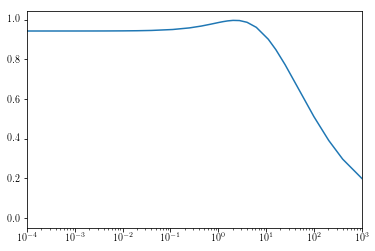

In [7]:
plt.semilogx(electronenergy, ys)
plt.xlim(1e-4,1e3)

In [8]:
list(zip(electronenergy, ys))

[(1000000000000.0, 6.928181464679343e-06),
 (111100000000.0, 2.0785453090497418e-05),
 (10000000000.0, 6.927985578709009e-05),
 (1111000000.0, 0.00020783690017708346),
 (100000000.0, 0.00069260271067481084),
 (11110000.0, 0.0020766069769424505),
 (1000000.0, 0.00690648115017137),
 (111100.0, 0.020590910574523291),
 (40000.0, 0.034102282962173124),
 (20410.0, 0.047443611951461788),
 (10000.0, 0.067148405382002591),
 (4444.0, 0.099163708197269426),
 (2500.0, 0.13017182278281925),
 (1111.0, 0.18931386370372316),
 (400.0, 0.29674370557004848),
 (204.1, 0.39105257913286179),
 (100.0, 0.51110924261064361),
 (44.44, 0.66433873645601171),
 (25.0, 0.77269416741102259),
 (16.0, 0.8485465202995498),
 (11.11, 0.90103262034365117),
 (6.25, 0.9607893310491824),
 (4.0, 0.98626041255065855),
 (2.778, 0.99499864266609517),
 (2.041, 0.99584155639178107),
 (1.562, 0.99316608678270779),
 (1.235, 0.98914384445631853),
 (1.0, 0.98477070434743219),
 (0.6944, 0.97665550457099726),
 (0.4444, 0.9673621470828374

In [25]:
gaunt_bound_free(2,0,1e-20*Ry_in_erg, 1, .000025*Ry_in_erg)

0.93468314972725575